In [1]:
import sympy as smp
import matplotlib.pyplot as plt
smp.init_printing(use_latex='mathjax')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
from xnp import *
backend = 'cupy' if getattr(np, '__name__', '') == 'cupy' else 'numpy'
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using CuPy on an Nvidia GPU


In [2]:
#Lets find some entropy

In [3]:
rmax = 1000000000
num = 500

In [4]:
#lets do a 4d planar BH
d=4
k=0
#placeholders for other vars
# the issue with these guys is that i have absolutely zero clue what "sensible" values would be for these
l=1
q=0

In [5]:
#lets define some functions?
def mu(R,d=d,k=k,l=l,q=q):
    return (R**(d-2))*(k+(q**2)/(R**(2*d-4))+(R**2)/(l**2))
def f(r,R,l=l,q=q,d=d,k=k):
    return k - mu(R)/(r**(d-2)) + (q**2)/(r**(2*d-4)) + (r**2)/(l**2)

def fp(r,R,l=l,q=q,d=d):
    return (d-2)*mu(R,d,k,l,q)/(r**(d-3)) + (4-2*d)*(q**2)/(r**(2*d-5))+ 2*r/(l**2)

def beta(R):
    return 4 * np.pi / fp(R,R)

def gamma2(r0,R):
    return -1*f(r0,R)*(r0**(2*d-4))

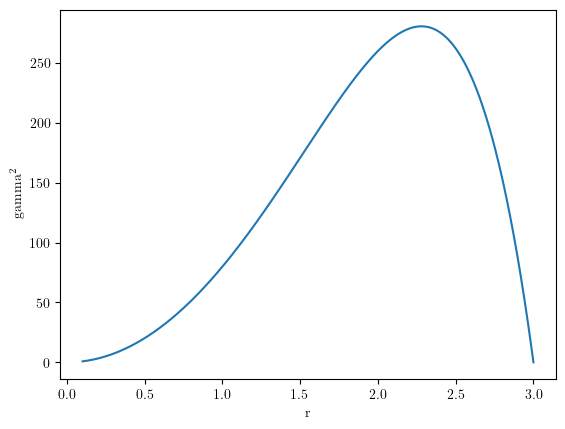

In [34]:
plt.plot(np.linspace(0.1,3,1000).get(),gamma2(np.linspace(0.1,3,1000),3).get())
plt.ylabel(r'gamma$^2$')
plt.xlabel('r')
plt.show()

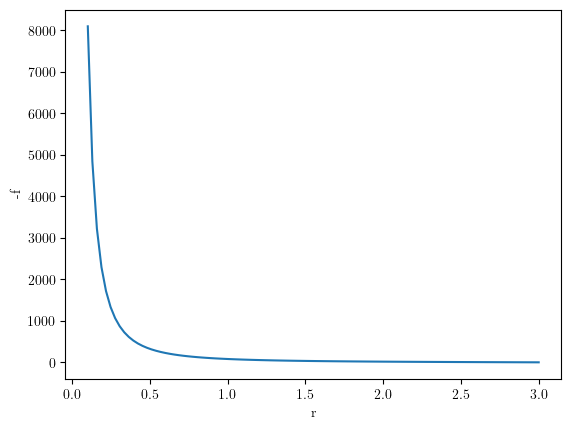

In [29]:
plt.plot(np.linspace(0.1,3,100).get(),-f(np.linspace(0.1,3,100),3).get())
# plt.semilogy()
plt.ylabel('-f')
plt.xlabel("r")
plt.show()

In [30]:
f(np.linspace(0.1,3,100),3).max()

array(0.)

In [18]:
#lets get a nice correlation between alpha and r0
# tried to keep this all vectorized, but was getting weird outputs and not the right divergences so its time for for loops (yippee!!!)
def k1(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rbar = 1#R / 2
        rgrid = np.linspace(rbar,r0,num)
        integ = 1/f(rgrid,R)
        mask = np.isfinite(integ)
        sum =  (4 * np.pi / beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k2(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.logspace(np.log10(R+0.001),np.log10(rmax),num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
        mask = np.isfinite(integ)
        sum = (2*np.pi/beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k3(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.linspace(r0,R-0.1,num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R))))/f(rgrid,R))
        mask = np.isfinite(integ)
        sum = (4*np.pi/beta(R)) * np.trapz(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

In [ ]:
# ok debug thoughts
# why is the expression inside the sqrt negative for most of the interior??
# could either take real component or ignore nans like i am now, both feel hacky and not great
# what do i do???

In [36]:
R=3
r0=2
rgrid=np.linspace(r0,R,100)
1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R))

array([ 0.        , -0.00506517, -0.01000172, -0.01480574, -0.01947328,
       -0.02400034, -0.02838285, -0.03261667, -0.03669761, -0.04062141,
       -0.04438376, -0.04798029, -0.05140654, -0.054658  , -0.05773012,
       -0.06061824, -0.06331766, -0.06582362, -0.06813127, -0.0702357 ,
       -0.07213195, -0.07381497, -0.07527965, -0.0765208 , -0.07753316,
       -0.07831141, -0.07885014, -0.07914389, -0.07918711, -0.07897417,
       -0.07849939, -0.07775698, -0.07674109, -0.07544582, -0.07386514,
       -0.07199297, -0.06982317, -0.06734947, -0.06456558, -0.06146507,
       -0.05804146, -0.05428819, -0.05019861, -0.04576599, -0.04098349,
       -0.03584422, -0.0303412 , -0.02446732, -0.01821545, -0.01157831,
       -0.00454857,  0.0028812 ,  0.01071853,  0.01897103,  0.02764641,
        0.03675247,  0.04629709,  0.05628827,  0.06673409,  0.07764271,
        0.08902242,  0.10088159,  0.11322868,  0.12607226,  0.13942099,
        0.15328365,  0.16766909,  0.1825863 ,  0.19804433,  0.21

In [19]:
def alpha(r0grid,R):
    return 2*np.exp(k1(r0grid,R)+k2(r0grid,R)+k3(r0grid,R))

In [20]:
#lets get an array relating r0 to alpha for fixed R=10
R = 3
r0grid = np.linspace(0.1,R-0.01,num)
alphagrid = alpha(r0grid,R)

k1grid = k1(r0grid,R)


k2grid = k2(r0grid,R)


k3grid = k3(r0grid,R)



# need to convert from CuPy array to NumPy array, something about being on the GPU.. if this breaks on mac just comment it all out lol
k1grid = k1grid.get()
k2grid = k2grid.get()
k3grid = k3grid.get()
r0grid = r0grid.get()
alphagrid = alphagrid.get()

In [21]:
k2grid

array([63.78385291, 60.67890024, 57.80863967, 55.15531492, 52.70199355,
       50.43269453, 48.33245799, 46.3873714 , 44.5845636 , 42.91217617,
       41.35931949, 39.91601918, 38.57315703, 37.32240976, 36.15618772,
       35.06757511, 34.05027281, 33.09854438, 32.20716565, 31.37137804,
       30.58684554, 29.8496154 , 29.15608219, 28.50295519, 27.88722873,
       27.30615543, 26.75722194, 26.23812701, 25.74676179, 25.28119196,
       24.83964167, 24.42047902, 24.02220301, 23.64343171, 23.28289163,
       22.9394081 , 22.61189658, 22.29935481, 22.00085571, 21.71554096,
       21.44261517, 21.1813406 , 20.93103238, 20.69105416, 20.46081419,
       20.23976166, 20.0273835 , 19.82320139, 19.626769  , 19.43766959,
       19.25551366, 19.07993696, 18.91059855, 18.74717908, 18.58937924,
       18.43691822, 18.28953247, 18.14697441, 18.0090113 , 17.87542425,
       17.74600723, 17.62056617, 17.4989182 , 17.38089084, 17.26632135,
       17.15505608, 17.04694986, 16.94186547, 16.83967313, 16.74

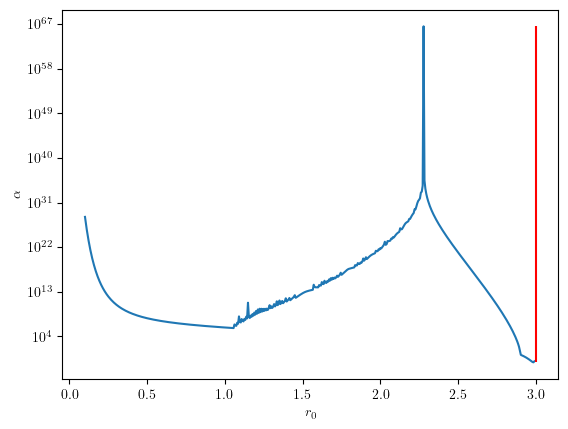

In [23]:
plt.plot(r0grid,alphagrid,label=r'$\alpha$')
plt.xlabel(r'$r_0$')
plt.ylabel(r'$\alpha$')
plt.vlines(R,alphagrid.min(),alphagrid.max(),colors='r',label="Horizon")
plt.semilogy()
# plt.xlim((9,10))
# plt.ylim((1,10))
plt.show()

In [24]:
#now just have to integrate our area functional from inf to R, from R to r0...
#i guess we can just do this a million billion times, varying alpha -> varying r0
#this will be so fun yippee!!!!

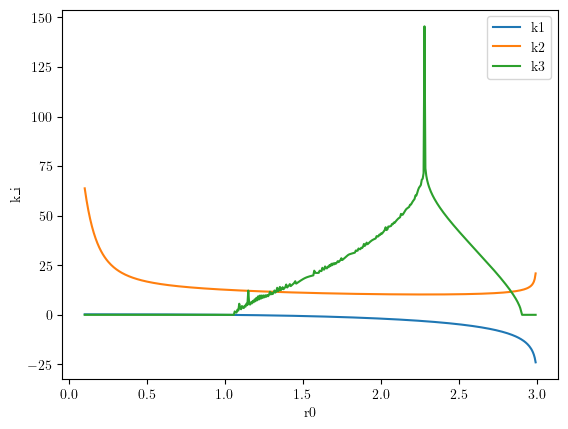

In [26]:
plt.plot(r0grid,k1grid,label='k1')
plt.plot(r0grid,k2grid,label='k2')
plt.plot(r0grid,k3grid,label='k3')
plt.xlabel('r0')
plt.ylabel('k_i')
plt.legend()
# plt.semilogx()
# plt.semilogy()
plt.show()

In [15]:
def det(rgrid,R):
    # rough estimate of r_crit in EQ 40 of 1405.7365
    eqgrid = fp(rgrid,R)*rgrid+(2*d-4)*f(rgrid,R)
    print(f'eqgrid: {eqgrid}')
    print(f'abseqgrid: {np.abs(eqgrid)}')
    minloc = np.argmin(np.abs(eqgrid))
    return eqgrid[minloc],rgrid[minloc]

In [16]:
det(np.linspace(0.001,R,1000000),R)

eqgrid: [-3.23999838e+08 -3.22065191e+08 -3.20147821e+08 ...  1.79999640e+02
  1.79999820e+02  1.80000000e+02]
abseqgrid: [3.23999838e+08 3.22065191e+08 3.20147821e+08 ... 1.79999640e+02
 1.79999820e+02 1.80000000e+02]


(array(0.00038569), array(1.36763667))

In [17]:
# ok so like
# divergences are absolutely NOT what the taylor series in paper would suggest (except for k1 and like the rightmost bit of k2)
# k3 should blow up around 1.367 but certainly does not do that
# honestly tho i have no clue what is going on rn
# may f0 and r0 are bad who knows